### features:
* selected spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet of level 0

In [1]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
import itertools

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
csv_path = "/Users/ecem/Desktop/csv of scgs"
wavelet_csv = "/Users/ecem/Desktop/wavelet-csv"

## Load data

Here, our target is to predict disease correctly. So; our y will be disease column of  dataset

## Training data

In [13]:
spec_t = pd.read_csv(csv_path + '/p-value-selected-intersection-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc_t = pd.read_csv(csv_path + '/signal_processing.csv', index_col = 0)
labels= signal_proc_t.disease

zero_crossing_t = signal_proc_t.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram_t = pd.read_csv(csv_path + '/p-value-selected-tempogram-union.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram_t = pd.read_csv(csv_path + '/p-value-selected-union-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0_t = pd.read_csv(csv_path+ '/wavelet_lvl0.csv', index_col = 0).drop(['disease'], axis =1)
#w_lvl0  #uncomment to see dataframe

In [14]:
w_lvl0_t

,lvl0_x0,lvl0_x1,lvl0_x2,lvl0_x3,lvl0_x4,lvl0_x5,lvl0_x6,lvl0_x7,lvl0_x8,lvl0_x9,...,lvl0_z38,lvl0_z39,lvl0_z40,lvl0_z41,lvl0_z42,lvl0_z43,lvl0_z44,lvl0_z45,lvl0_z46,lvl0_z47
0,-0.503078,-0.508493,-0.495124,-0.461686,-0.327573,-0.463505,-0.319357,-0.290070,-0.372214,-0.670804,...,-0.004803,-0.009975,-0.013297,0.031506,0.034660,0.121152,0.158909,0.128339,0.134332,0.149062
1,-0.337088,-0.358658,-0.344212,-0.297174,-0.193528,-0.346729,-0.177544,-0.201896,-0.263341,-0.287319,...,-0.056027,-0.044484,-0.025730,0.040819,-0.007631,-0.004883,-0.056402,-0.067213,-0.057641,-0.039950
2,-0.382271,-0.409044,-0.397055,-0.353910,-0.297396,-0.389712,-0.234055,-0.194504,-0.231223,-0.298895,...,0.017353,0.029110,0.004084,-0.041428,-0.044852,-0.034972,0.053526,0.039660,0.035398,0.031143
3,0.071162,0.089320,0.064081,-0.037265,-0.353574,-0.289820,-0.397483,-0.365879,-0.382827,-0.204690,...,0.052188,-0.078633,-0.044265,-0.024217,-0.029692,0.051737,0.043672,0.048377,0.047015,0.038573
4,-0.790181,-0.790978,-0.778167,-0.723883,-0.509830,-0.586515,-0.283325,-0.336158,-0.268263,-0.318504,...,-0.014478,0.017597,-0.019702,-0.037006,0.019880,0.066369,0.091973,0.078102,0.079841,0.083903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.254162,0.256369,0.261570,0.288534,0.391812,0.492755,0.414114,0.194791,-0.130332,-0.118806,...,0.014821,0.009703,0.038727,0.016893,0.051154,0.023889,0.014518,0.018233,0.018315,0.018180
1456,0.349622,0.321284,0.310296,0.278119,0.003263,-0.149820,-0.205826,-0.210372,-0.252378,-0.305266,...,0.006079,-0.028282,-0.056236,-0.020658,-0.042306,-0.025261,0.045890,0.026822,0.025429,0.030637
1457,-0.163857,-0.138495,-0.157529,-0.233442,-0.414839,-0.340551,-0.398183,-0.368650,-0.085265,0.094994,...,-0.026788,-0.088121,-0.051529,-0.048913,-0.070555,-0.049824,-0.080925,-0.069791,-0.070239,-0.077539
1458,-0.383882,-0.363848,-0.364389,-0.366114,-0.272939,0.017750,0.177799,0.347536,0.578930,0.653146,...,-0.055060,-0.042704,-0.035764,-0.022767,0.005606,0.042350,0.034094,0.036432,0.035644,0.033274


In [15]:
features_t = pd.concat([spec_t, w_lvl0_t], axis = 1)
features_t = pd.concat([features_t, zero_crossing_t], axis = 1)
features_t = pd.concat([features_t, chromogram_t], axis = 1)
features_t = pd.concat([features_t, tempogram_t], axis = 1)

features_t

,freq_y1772,freq_z1773,freq_y1774,freq_z1774,freq_x555,freq_y555,freq_z555,freq_x556,freq_y556,freq_z556,...,tempogram_z106,tempogram_y112,tempogram_x116,tempogram_y207.1,tempogram_y227.1,tempogram_z246,tempogram_z253,tempogram_y353,tempogram_y370,tempogram_z374.1
0,0.001532,0.001638,0.001677,0.001672,0.001892,0.001941,0.002010,0.002093,0.002200,0.002322,...,4.494106e-17,2.962999e-17,6.733245e-17,-2.724992e-17,1.186894e-17,4.947992e-17,3.143395e-17,-2.013831e-17,-2.173347e-17,5.255093e-17
1,0.001083,0.001132,0.001141,0.001149,0.001957,0.001952,0.001978,0.002046,0.002179,0.002357,...,2.742302e-17,4.300870e-17,4.590532e-17,-1.337395e-17,1.154142e-17,-5.012637e-20,3.352991e-17,-1.643196e-17,-3.131140e-17,4.355038e-17
2,0.000997,0.001008,0.001048,0.001075,0.001647,0.001770,0.001908,0.002053,0.002199,0.002335,...,5.695394e-17,5.434512e-17,4.959943e-17,2.657111e-18,2.726203e-17,2.511922e-17,2.399343e-17,-9.669493e-18,-4.787120e-17,7.317623e-17
3,0.001562,0.001503,0.001520,0.001516,0.001810,0.001874,0.001938,0.002015,0.002086,0.002144,...,4.002449e-17,3.704987e-17,5.075071e-17,-3.994002e-17,2.930543e-17,2.386421e-17,3.700749e-17,-1.438568e-17,-2.220229e-17,8.881837e-17
4,0.001470,0.001204,0.001127,0.001114,0.002247,0.002255,0.002247,0.002222,0.002186,0.002146,...,5.836358e-17,6.028812e-17,7.356340e-17,-1.411388e-17,1.736420e-17,1.512212e-17,3.730192e-17,-2.694114e-17,-7.030712e-17,2.926575e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.001078,0.001225,0.001262,0.001274,0.002092,0.001987,0.001902,0.001843,0.001815,0.001815,...,3.274181e-17,4.080143e-17,3.002664e-17,1.322290e-17,3.625893e-17,1.105587e-17,2.601346e-17,-3.514779e-19,-2.330293e-17,7.273644e-17
1456,0.001541,0.001603,0.001553,0.001534,0.001942,0.001951,0.001939,0.001905,0.001852,0.001789,...,4.402990e-17,4.736565e-17,4.041930e-17,3.118530e-19,3.561906e-17,4.093931e-17,4.207797e-17,8.008623e-18,-3.206030e-17,9.019197e-17
1457,0.001214,0.001122,0.001129,0.001130,0.002109,0.002055,0.002006,0.001959,0.001909,0.001862,...,6.571730e-17,7.123703e-17,7.050584e-17,-2.603978e-17,1.424453e-17,2.042900e-17,4.225717e-17,5.550884e-18,-5.380471e-17,7.213398e-17
1458,0.001335,0.001130,0.001096,0.001092,0.002863,0.002948,0.003014,0.003062,0.003079,0.003065,...,3.243106e-17,5.146443e-17,3.075446e-17,-3.008675e-17,1.116627e-17,-3.201455e-18,4.965608e-18,5.104215e-18,-4.635523e-17,8.280988e-17


In [16]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(labels)
label

array([2, 2, 2, ..., 1, 1, 1])

In [17]:
le.classes_

array(['AR', 'AS', 'MR', 'MS'], dtype=object)

## Test data

In [18]:
spec = pd.read_csv(csv_path + '/p-value-selected-intersection-multiple-dis-spec.csv', index_col = 0)
#spec  #uncomment to see dataframe

signal_proc = pd.read_csv(csv_path + '/multiple-disease-final-signal_processing.csv', index_col = 0)
y1 = signal_proc.disease1
y2 = signal_proc.disease2

zero_crossing = signal_proc.iloc[:,:21]
#zero_crossing #uncomment to see dataframe

tempogram = pd.read_csv(csv_path + '/p-value-selected-multiple-dis-union-temp.csv', index_col = 0)
#tempogram #uncomment to see dataframe

chromogram = pd.read_csv(csv_path + '/p-value-selected-multiple-dis-union-chromogram.csv', index_col = 0)
#chromogram #uncomment to see dataframe

w_lvl0 = pd.read_csv(csv_path + '/multiple-disease-wavelet-lvl0-coef.csv', index_col = 0).drop(['disease1', 'disease2'], axis =1)
w_lvl0 = w_lvl0.reset_index(drop=True)
#w_lvl0  #uncomment to see dataframe

#wavelet =pd.read_csv(csv_path + '/p-value-selected-multiple-disease-mean-wavelet.csv', index_col = 0)

In [8]:
#spec

In [9]:
#signal_proc

In [10]:
#zero_crossing

In [11]:
#tempogram

In [12]:
#chromogram

In [13]:
#w_lvl0

In [19]:
features = pd.concat([spec, w_lvl0], axis = 1)
features = pd.concat([features, zero_crossing], axis = 1)
features = pd.concat([features, chromogram], axis = 1)
features = pd.concat([features, tempogram], axis = 1)

features

,freq_y1772,freq_z1773,freq_y1774,freq_z1774,freq_x555,freq_y555,freq_z555,freq_x556,freq_y556,freq_z556,...,tempogram_z106,tempogram_y112,tempogram_x116,tempogram_y207.1,tempogram_y227.1,tempogram_z246,tempogram_z253,tempogram_y353,tempogram_y370,tempogram_z374.1
0,0.000852,0.001024,0.001136,0.001179,0.001930,0.001909,0.001868,0.001814,0.001754,0.001702,...,9.994543e-17,1.232247e-16,1.001184e-16,-1.964399e-17,2.858973e-17,4.922341e-17,5.827835e-17,-4.917528e-17,-6.135036e-17,1.303190e-16
1,0.001324,0.001324,0.001297,0.001297,0.001352,0.001389,0.001451,0.001521,0.001591,0.001664,...,6.500303e-17,7.951070e-17,8.307684e-17,-1.700911e-18,4.507298e-17,7.025112e-17,4.275118e-17,-6.901380e-17,-9.207028e-17,1.089938e-16
2,0.000756,0.000766,0.000770,0.000777,0.001400,0.001370,0.001354,0.001366,0.001415,0.001496,...,4.465337e-17,5.101912e-17,4.457167e-17,-2.305105e-17,2.386353e-17,5.068512e-17,6.606533e-17,-3.673851e-17,-6.781394e-17,9.120288e-17
3,0.001296,0.001351,0.001377,0.001394,0.001408,0.001461,0.001525,0.001589,0.001652,0.001710,...,6.750549e-17,5.339907e-17,4.215830e-17,-3.972561e-17,2.592123e-17,2.682779e-17,6.410879e-17,-8.133388e-18,-6.925156e-17,3.225646e-17
4,0.001259,0.001474,0.001548,0.001574,0.001615,0.001637,0.001646,0.001636,0.001607,0.001559,...,2.857533e-17,8.348267e-17,5.107314e-17,-5.175299e-17,5.519621e-18,1.199940e-17,1.194157e-17,1.844420e-17,-4.256831e-17,1.134471e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,0.001908,0.002203,0.002244,0.002238,0.002802,0.002739,0.002655,0.002559,0.002466,0.002393,...,2.996399e-17,4.045839e-17,4.824219e-17,-3.395339e-17,2.404212e-17,5.710396e-17,5.973744e-17,-1.142948e-17,-9.505526e-18,3.933663e-17
351,0.001781,0.002088,0.002138,0.002148,0.004011,0.003909,0.003803,0.003701,0.003584,0.003453,...,5.678753e-17,9.653657e-17,1.023259e-16,-1.195967e-17,3.015963e-17,3.455005e-17,4.837653e-17,-5.919375e-18,-2.407264e-17,2.747967e-17
352,0.001544,0.001566,0.001579,0.001578,0.002893,0.002796,0.002694,0.002628,0.002590,0.002553,...,3.646589e-17,9.854131e-17,3.062525e-17,-3.045924e-18,4.937399e-17,1.867182e-17,9.180124e-19,-1.578804e-17,-4.080610e-17,3.521288e-17
353,0.000873,0.001025,0.001033,0.001021,0.002950,0.002898,0.002809,0.002688,0.002544,0.002399,...,3.561063e-17,1.697859e-17,2.734245e-17,-1.796821e-17,-9.914487e-18,1.487286e-17,1.593646e-17,-1.954006e-17,-2.247935e-17,4.214631e-17


In [20]:
y1 = le.transform(y1)
y1

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [21]:
y2 = le.transform(y2)
y2

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [22]:
stack = np.stack((y1,y2), axis = 1)
y = pd.DataFrame(stack, columns =['disease1', 'disease2'])
y

,disease1,disease2
0,2,1
1,2,1
2,2,1
3,2,1
4,2,1
...,...,...
350,3,2
351,3,2
352,3,2
353,3,2


In [23]:
X_train, X_valid, y_train, y_valid = train_test_split(features_t, label, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [24]:
import xgboost as xgb
model  = xgb.XGBClassifier(random_state = 42, objective='multi:softprob', eval_metric = 'merror') 

# Fit the model
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='merror', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [25]:
predictions = model.predict(X_valid)

In [26]:
predictions.shape

(292,)

In [27]:
prob = model.predict_proba(X_valid)
prob = np.moveaxis(prob, -1, 0)

In [28]:
prob.shape

(4, 292)

In [29]:
y['disease1']

0      2
1      2
2      2
3      2
4      2
      ..
350    3
351    3
352    3
353    3
354    3
Name: disease1, Length: 355, dtype: int64

In [30]:
df_results = pd.DataFrame({'actual':y_valid,
                           'prediction':predictions, 'probability of 0': prob[0],
                          'probability of 1': prob[1],
                          'probability of 2': prob[2], 
                          'probability of 3': prob[3],  })
df_results

,actual,prediction,probability of 0,probability of 1,probability of 2,probability of 3
0,3,3,0.010453,0.000639,0.003740,0.985168
1,1,2,0.000243,0.342112,0.657025,0.000621
2,2,2,0.002578,0.121667,0.873901,0.001854
3,2,2,0.000985,0.001072,0.997899,0.000043
4,1,1,0.000562,0.993593,0.005304,0.000542
...,...,...,...,...,...,...
287,2,2,0.002523,0.023315,0.957655,0.016506
288,1,1,0.000269,0.960515,0.039012,0.000204
289,0,0,0.997259,0.000341,0.002215,0.000185
290,0,0,0.672506,0.274136,0.036284,0.017074


In [26]:
AR_df  = df_results.loc[df_results['actual']== 0]
AR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,50.000000,50.000000,50.000000,50.000000
mean,0.883259,0.030319,0.083610,0.002811
std,0.246058,0.080555,0.193245,0.005478
min,0.000570,0.000040,0.000244,0.000018
25%,0.912596,0.000429,0.002000,0.000088
50%,0.985573,0.003268,0.008230,0.000455
75%,0.997581,0.009774,0.068835,0.003293
max,0.999631,0.401665,0.988963,0.026137


In [27]:
AS_df  = df_results.loc[df_results['actual']== 1]
AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,97.000000,97.000000,97.000000,97.000000
mean,0.004850,0.822344,0.167061,0.005745
std,0.013927,0.245045,0.239571,0.022622
min,0.000030,0.028272,0.000054,0.000006
25%,0.000358,0.749874,0.006962,0.000378
50%,0.000933,0.941293,0.044540,0.000940
75%,0.003510,0.991933,0.231548,0.002807
max,0.116428,0.999892,0.970788,0.208190


In [28]:
MR_df  = df_results.loc[df_results['actual']== 2]
MR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,118.000000,118.000000,118.000000,118.000000
mean,0.051223,0.090870,0.853362,0.004546
std,0.182589,0.170327,0.244973,0.012861
min,0.000034,0.000290,0.032311,0.000030
25%,0.000253,0.003703,0.832599,0.000233
50%,0.000803,0.020035,0.967057,0.000499
75%,0.004528,0.072862,0.991666,0.001899
max,0.965437,0.848493,0.999320,0.087351


In [29]:
MS_df  = df_results.loc[df_results['actual']== 3]
MS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,28.000000,28.000000,28.000000,28.000000
mean,0.065794,0.020695,0.100275,0.813237
std,0.162514,0.031693,0.250593,0.319306
min,0.000032,0.000081,0.000050,0.001867
25%,0.000084,0.002598,0.000987,0.810881
50%,0.000398,0.007184,0.003196,0.985163
75%,0.002752,0.020025,0.041414,0.997057
max,0.595792,0.117038,0.976693,0.999541


In [31]:
predictions_test = model.predict(features)

In [32]:
predictions_test.shape

(355,)

In [33]:
prob_test = model.predict_proba(features)
prob_test = np.moveaxis(prob_test, -1, 0)

In [34]:
prob_test.shape

(4, 355)

In [35]:
df_results_test = pd.DataFrame({'actual disease1': y['disease1'], 'actual disease2': y['disease2'],
                                'prediction':predictions_test, 'probability of 0': prob_test[0],
                          'probability of 1': prob_test[1],
                          'probability of 2': prob_test[2], 
                          'probability of 3': prob_test[3]  })
df_results_test

,actual disease1,actual disease2,prediction,probability of 0,probability of 1,probability of 2,probability of 3
0,2,1,0,0.826817,0.016278,0.129182,0.027723
1,2,1,1,0.021020,0.736957,0.170844,0.071180
2,2,1,2,0.032565,0.454477,0.501609,0.011350
3,2,1,1,0.007696,0.940757,0.037890,0.013657
4,2,1,1,0.000465,0.989821,0.009271,0.000442
...,...,...,...,...,...,...,...
350,3,2,3,0.044627,0.303735,0.244221,0.407417
351,3,2,1,0.055733,0.524198,0.207978,0.212091
352,3,2,2,0.025136,0.355844,0.484721,0.134299
353,3,2,2,0.068111,0.143974,0.711277,0.076639


In [36]:
y 
#mr as  #2 1
#mr ar  #2 0
#ar as  #0 1
#ms as  #3 1
#ms mr  #3 2


,disease1,disease2
0,2,1
1,2,1
2,2,1
3,2,1
4,2,1
...,...,...
350,3,2
351,3,2
352,3,2
353,3,2


In [36]:
MR_AS_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 2) &
                                 (df_results_test['actual disease2']== 1))]
#MR_AS_df
MR_AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.226414,0.264530,0.381543,0.136341
min,0.000106,0.002258,0.002739,0.000095
25%,0.002256,0.034454,0.111732,0.001333
50%,0.008639,0.136206,0.742705,0.005795
75%,0.052474,0.394246,0.936153,0.109546
max,0.978036,0.930744,0.993544,0.876279


In [37]:
MR_AR_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 2) &
                                 (df_results_test['actual disease2']== 0))]
#MR_AR_df
MR_AR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.226414,0.264530,0.381543,0.136341
min,0.000106,0.002258,0.002739,0.000095
25%,0.002256,0.034454,0.111732,0.001333
50%,0.008639,0.136206,0.742705,0.005795
75%,0.052474,0.394246,0.936153,0.109546
max,0.978036,0.930744,0.993544,0.876279


In [38]:
MR_test_df1  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 2))]
#MR_test_df1
MR_test_df1[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,164.000000,164.000000,164.000000,164.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.225718,0.263717,0.380370,0.135922
min,0.000106,0.002258,0.002739,0.000095
25%,0.002210,0.033537,0.111396,0.001326
50%,0.008639,0.136206,0.742705,0.005795
75%,0.053960,0.399919,0.938119,0.112397
max,0.978036,0.930744,0.993544,0.876279


In [39]:
MR_test_df2  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease2']== 2))]
#MR_test_df2
MR_test_df2[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,38.000000,38.000000,38.000000,38.000000
mean,0.052919,0.214500,0.504977,0.227604
std,0.144275,0.218199,0.330577,0.238244
min,0.000196,0.009945,0.008722,0.000844
25%,0.000535,0.041123,0.205195,0.032351
50%,0.001156,0.102483,0.455346,0.151350
75%,0.007267,0.392076,0.844946,0.352438
max,0.633702,0.755220,0.970408,0.939075


In [40]:
AR_AS_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 0) &
                                 (df_results_test['actual disease2']== 1))]
#AR_AS_df
AR_AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,43.000000,43.000000,43.000000,43.000000
mean,0.001225,0.051985,0.896076,0.050714
std,0.004813,0.089275,0.192586,0.134087
min,0.000074,0.000959,0.073360,0.000113
25%,0.000132,0.004220,0.894892,0.000379
50%,0.000233,0.012005,0.976621,0.001388
75%,0.000499,0.046695,0.994763,0.015253
max,0.031722,0.341162,0.998531,0.553756


In [41]:
AR_test_df1  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 0))]
#AR_test_df1
AR_test_df1[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,43.000000,43.000000,43.000000,43.000000
mean,0.001225,0.051985,0.896076,0.050714
std,0.004813,0.089275,0.192586,0.134087
min,0.000074,0.000959,0.073360,0.000113
25%,0.000132,0.004220,0.894892,0.000379
50%,0.000233,0.012005,0.976621,0.001388
75%,0.000499,0.046695,0.994763,0.015253
max,0.031722,0.341162,0.998531,0.553756


In [43]:
AR_test_df2  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease2']== 0))]
#AR_test_df2
AR_test_df2[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.110012,0.247149,0.570817,0.072023
std,0.226414,0.264530,0.381543,0.136341
min,0.000106,0.002258,0.002739,0.000095
25%,0.002256,0.034454,0.111732,0.001333
50%,0.008639,0.136206,0.742705,0.005795
75%,0.052474,0.394246,0.936153,0.109546
max,0.978036,0.930744,0.993544,0.876279


In [44]:
MS_AS_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 3) &
                                 (df_results_test['actual disease2']== 1))]
#MS_AS_df
MS_AS_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,82.000000,82.000000,82.000000,82.000000
mean,0.002458,0.427303,0.565004,0.005235
std,0.003985,0.356188,0.357815,0.005886
min,0.000100,0.002270,0.015346,0.000464
25%,0.000471,0.026320,0.210880,0.001679
50%,0.001221,0.415583,0.561619,0.003217
75%,0.002527,0.776531,0.970869,0.007130
max,0.028033,0.983187,0.995849,0.032992


In [45]:
MS_MR_df  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 3) &
                                 (df_results_test['actual disease2']== 2))]
#MS_MR_df
MS_MR_df[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,38.000000,38.000000,38.000000,38.000000
mean,0.052919,0.214500,0.504977,0.227604
std,0.144275,0.218199,0.330577,0.238244
min,0.000196,0.009945,0.008722,0.000844
25%,0.000535,0.041123,0.205195,0.032351
50%,0.001156,0.102483,0.455346,0.151350
75%,0.007267,0.392076,0.844946,0.352438
max,0.633702,0.755220,0.970408,0.939075


In [46]:
MS_test_df1  = df_results_test.iloc[np.where
                                ((df_results_test['actual disease1']== 3))]
#MS_test_df1
MS_test_df1[['probability of 0', 'probability of 1', 'probability of 2', 'probability of 3']].describe()

,probability of 0,probability of 1,probability of 2,probability of 3
count,120.000000,120.000000,120.000000,120.000000
mean,0.018438,0.359915,0.545996,0.075652
std,0.083895,0.333229,0.349159,0.168706
min,0.000100,0.002270,0.008722,0.000464
25%,0.000489,0.038765,0.205807,0.002292
50%,0.001221,0.261529,0.521713,0.005764
75%,0.002791,0.643598,0.921797,0.030647
max,0.633702,0.983187,0.995849,0.939075


In [37]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y.disease1, predictions_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y.disease1, predictions_test, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y.disease1, predictions_test, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

Accuracy: 13.24%
recall: 13.24%
precision: 27.01%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [38]:
accuracy = accuracy_score(y.disease2, predictions_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

recall = recall_score(y.disease2, predictions_test, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))

from sklearn.metrics import precision_score
precision = precision_score(y.disease2, predictions_test, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

Accuracy: 29.30%
recall: 29.30%
precision: 42.86%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
classes = ['AR', 'AS', 'MR', 'MS']

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


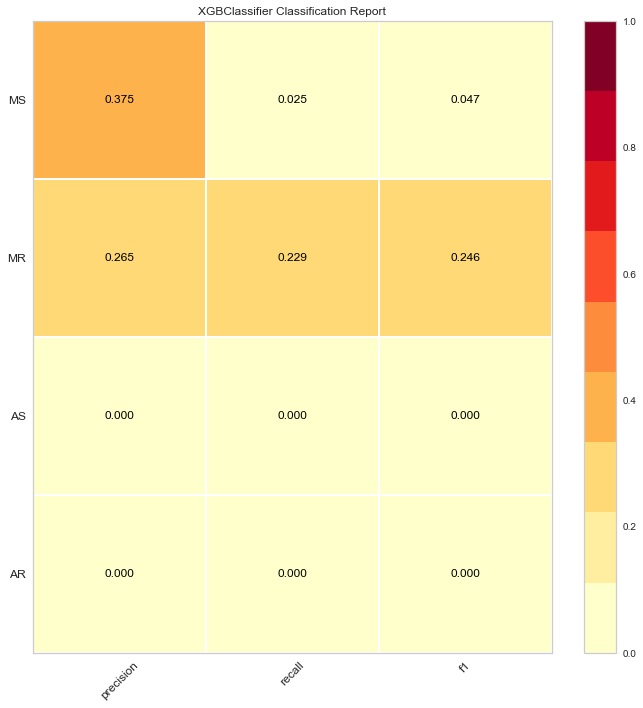

In [40]:
report = ClassificationReport(model, size=(700, 720), classes=classes)

report.score(features, y.disease1)
c = report.poof()

/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/yellowbrick/classifier/base.py:232: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  warnings.warn(
/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


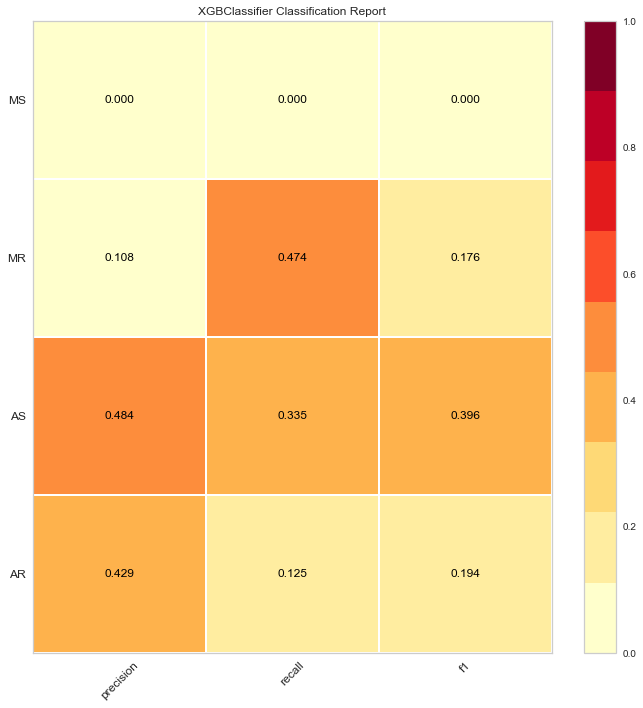

In [41]:
report = ClassificationReport(model, size=(700, 720), classes=classes)

report.score(features, y.disease2)
c = report.poof()